In [1]:
import logging
import sys

import datasets
import huggingface_hub
import torch
import transformers

transformers.logging.set_verbosity_error()
datasets.logging.set_verbosity_error()

# Logging is only available for the chapters that don't depend on Haystack
if huggingface_hub.__version__ == "0.0.19":
    huggingface_hub.logging.set_verbosity_error()

In [2]:
import torch
torch.__version__, torch.cuda.is_available()

('2.0.0', True)

## The Dataset

In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 32183 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


We see that each dataset is given a name, so let's load the `emotion` dataset with the `load_dataset()` function:

In [4]:
# hide_output
from datasets import load_dataset

imdb = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

If we look inside our `imdb` object:

In [5]:
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [6]:
train_ds = imdb["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

which returns an instance of the `Dataset` class. The `Dataset` object is one of the core data structures in image:images/logo.png[hf,13,13] Datasets, and we'll be exploring many of its features throughout the course of this book. For starters, it behaves like an ordinary Python array or list, so we can query its length:

In [7]:
len(train_ds)

25000

or access a single example by its index:

In [8]:
train_ds[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

Here we see that a single row is represented as a dictionary, where the keys correspond to the column names:

In [9]:
train_ds.column_names

['text', 'label']

and the values are the tweet and the emotion. This reflects the fact that image:images/logo.png[hf,13,13] Datasets is based on [_Apache Arrow_](https://arrow.apache.org/), which defines a typed columnar format that is more memory efficient than native Python. We can see what data types are being used under the hood by accessing the `features` attribute of a `Dataset` object:

In [10]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In this case, the data type of the `text` column is `string`, while the `label` column is a special `ClassLabel` object that contains information about the class names and their mapping to integers. We can also access several rows with a slice:

In [11]:
print(train_ds[:5])

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

Note that in this case, the dictionary values are now lists instead of individual elements. We can also get the full column by name:

In [12]:
print(train_ds["text"][:5])

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

Now that we've seen how to load and inspect data with image:images/logo.png[hf,13,13] Datasets, let's do a few sanity checks about the content of our tweets.

### From Datasets to DataFrames

Although image:images/logo.png[hf,13,13] Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a `Dataset` object to a Pandas `DataFrame` so we can access high-level APIs for data visualization. To enable the conversion, image:images/logo.png[hf,13,13] Datasets provides a `set_format()` method that allows us to change the _output format_ of the `Dataset`. Note that this does not change the underlying _data format_ (which is an Arrow table), and you can switch to another format later if needed:

In [13]:
import pandas as pd

imdb.set_format(type="pandas")
df = imdb["train"][:]
df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


As you can see, the column headers have been preserved and the first few rows match our previous views of the data. However, the labels are represented as integers, so let's use the `int2str()` method of the `label` feature to create a new column in our `DataFrame` with the corresponding label names:

In [14]:
imdb["train"].features["label"].int2str

<bound method ClassLabel.int2str of ClassLabel(names=['neg', 'pos'], id=None)>

In [16]:
def label_int2str(row):
    return imdb["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,neg
1,"""I Am Curious: Yellow"" is a risible and preten...",0,neg
2,If only to avoid making this type of film in t...,0,neg
3,This film was probably inspired by Godard's Ma...,0,neg
4,"Oh, brother...after hearing about this ridicul...",0,neg


Before diving into building a classifier, let's take a closer look at the dataset. As Andrej Karpathy notes in his famous blog post ["A Recipe for Training Neural Networks"](https://karpathy.github.io/2019/04/25/recipe), becoming "one with the data" is an essential step for training great models!

### Looking at the Class Distribution

Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one. 

With Pandas and Matplotlib, we can quickly visualize the class distribution as follows:

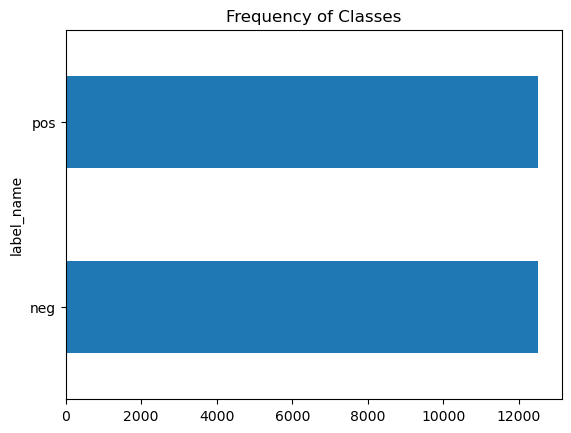

In [17]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In this case, we can see that the dataset is balanced.

### How Long Are Our Reviews?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. As we'll see in the next section, a token is an atomic piece of text; for now, we'll treat a token as a single word. We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet:

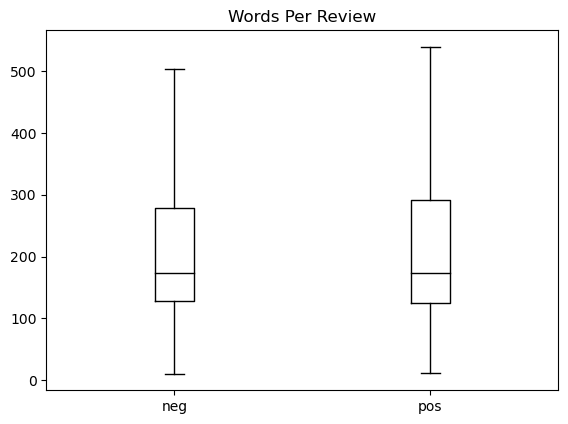

In [18]:
df["Words Per Review"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Review", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [27]:
df["Words Per Review"].max()

2470

If max size is 512, we have to truncate the reviews...

In [19]:
df["Words Per Review"].mean()

233.7872

Tweets in the initial example were much shorter in comparison. This might be an issue.

Let's now figure out how we can convert these raw texts into a format suitable for image:images/logo.png[hf,13,13] Transformers! While we're at it, let's also reset the output format of our dataset since we don't need the `DataFrame` format anymore: 

In [20]:
imdb.reset_format()

## From Text to Tokens

### Word Tokenization

Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.

One simple class of word tokenizers uses whitespace to tokenize the text. We can do this by applying Python's `split()` function directly on the raw text (just like we did to measure the tweet lengths):

In [23]:
text = df['text'].iloc[0]

In [24]:
tokenized_text = text.split()
print(tokenized_text)

['I', 'rented', 'I', 'AM', 'CURIOUS-YELLOW', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967.', 'I', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'U.S.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country,', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', '"controversial"', 'I', 'really', 'had', 'to', 'see', 'this', 'for', 'myself.<br', '/><br', '/>The', 'plot', 'is', 'centered', 'around', 'a', 'young', 'Swedish', 'drama', 'student', 'named', 'Lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life.', 'In', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'Swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'Vietnam', 'War', 'and', 'race', 'issues', 'in', 'the',

### Subword Tokenization

The basic idea behind subword tokenization is to combine the best aspects of character and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is _learned_ from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let's start with WordPiece,footnote:[M. Schuster and K. Nakajima, "Japanese and Korean Voice Search," _2012 IEEE International Conference on Acoustics, Speech and Signal Processing_ (2012): 5149–5152, https://doi.org/10.1109/ICASSP.2012.6289079.] which is used by the BERT and DistilBERT tokenizers. The easiest way to understand how WordPiece works is to see it in action. image:images/logo.png[hf,13,13] Transformers provides a convenient `AutoTokenizer` class that allows you to quickly load the tokenizer associated with a pretrained model—we just call its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path. Let's start by loading the tokenizer for DistilBERT:

In [25]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The `AutoTokenizer` class belongs to a larger set of ["auto" classes](https://huggingface.co/docs/transformers/model_doc/auto) whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

```python
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

> note: When you run the `AutoTokenizer.from_pretrained()` method for the first time you will see a progress bar that shows which parameters of the pretrained tokenizer are loaded from the Hugging Face Hub. When you run the code a second time, it will load the tokenizer from the cache, usually located at _~/.cache/huggingface/_.

Let's examine how this tokenizer works by feeding it our simple "Tokenizing text is a core task of NLP." example text:

In [26]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 383

Just like we saw with character tokenization, we can see that the words have been mapped to unique integers in the `input_ids` field. We'll discuss the role of the `attention_mask` field in the next section. Now that we have the `input_ids`, we can convert them back into tokens by using the tokenizer's `convert_ids_to_tokens()` method:

In [28]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'i', 'rented', 'i', 'am', 'curious', '-', 'yellow', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'u', '.', 's', '.', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', ',', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', '"', 'controversial', '"', 'i', 'really', 'had', 'to', 'see', 'this', 'for', 'myself', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', '.', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attention', '##s', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'sw', '##ede', 'thought', 'about', 'certain', 'polit

We can observe three things here. First, some special `[CLS]` and `[SEP]` tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. Second, the tokens have each been lowercased, which is a feature of this particular checkpoint. Finally, we can see that "tokenizing" and "NLP" have been split into two tokens, which makes sense since they are not common words. The `##` prefix in `##izing` and `##p` means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string. The `AutoTokenizer` class has a `convert_tokens_to_string()` method for doing just that, so let's apply it to our tokens:

In [29]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] i rented i am curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. customs if it ever tried to enter this country, therefore being a fan of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes a

The `AutoTokenizer` class also has several attributes that provide information about the tokenizer. For example, we can inspect the vocabulary size:

In [30]:
tokenizer.vocab_size

30522

and the corresponding model's maximum context size:

In [31]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [32]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Now that we have a basic understanding of the tokenization process for a single string, let's see how we can tokenize the whole dataset!

> warning: When using pretrained models, it is _really_ important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. If everyone around you started swapping random words like "house" for "cat," you'd have a hard time understanding what was going on too!

### Tokenizing the Whole Dataset

To tokenize the whole corpus, we'll use the `map()` method of our `DatasetDict` object. We'll encounter this method many times throughout this book, as it provides a convenient way to apply a processing function to each element in a dataset. As we'll soon see, the `map()` method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [33]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [34]:
print(tokenize(imdb["train"][:2]))

{'input_ids': [[101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 38

In [35]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded tweets as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input. <<attention-mask>> provides a visual explanation of how the input IDs and attention masks are padded.

Once we've defined a processing function, we can apply it across all the splits in the corpus in a single line of code:

In [36]:
# hide_output
imdb_encoded = imdb.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the tweets in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [38]:
print(imdb_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


> Note: In later chapters, we'll see how _data collators_ can be used to dynamically pad the tensors in each batch. Padding globally will come in handy in the next section, where we extract a feature matrix from the whole corpus.

## Training a Text Classifier

We have two options to train such a model on our Twitter dataset:

- _Feature extraction_:: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
- _Fine-tuning_:: We train the whole model end-to-end, which also updates the parameters of the pretrained model. 

In the following sections we explore both options for DistilBERT and examine their trade-offs. 

### Transformers as Feature Extractors


Using a transformer as a feature extractor is fairly simple. As shown in <<encoder-features>>, we freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

#### Using pretrained models


We will use another convenient auto class from image:images/logo.png[hf,13,13] Transformers called `AutoModel`. Similar to the `AutoTokenizer` class, `AutoModel` has a `from_pretrained()` method to load the weights of a pretrained model. Let's use this method to load the DistilBERT checkpoint:

In [39]:
# hide_output
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Here we've used PyTorch to check whether a GPU is available or not, and then chained the PyTorch `nn.Module.to()` method to the model loader. This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The `AutoModel` class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

#### Extracting the last hidden states

In [44]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [45]:
imdb_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

We can then go ahead and extract the hidden states across all splits in one go:

In [48]:
#hide_output
imdb_hidden = imdb_encoded.map(extract_hidden_states, batched=True, batch_size=200)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [53]:
imdb_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 50000
    })
})

In [51]:
imdb_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix - let's take a look.

#### Creating a feature matrix

The preprocessed dataset now contains all the information we need to train a classifier on it. We will use the hidden states as input features and the labels as targets. We can easily create the corresponding arrays in the well-known Scikit-Learn format as follows:

In [54]:
import numpy as np

X_train = np.array(imdb_hidden["train"]["hidden_state"])
X_valid = np.array(imdb_hidden["test"]["hidden_state"])
y_train = np.array(imdb_hidden["train"]["label"])
y_valid = np.array(imdb_hidden["test"]["label"])
X_train.shape, X_valid.shape

((25000, 768), (25000, 768))

#### Visualizing the training set

Since visualizing the hidden states in 768 dimensions is tricky to say the least, we'll use the powerful UMAPfootnote:[L. McInnes, J. Healy, and J. Melville, ["UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction"](https://arxiv.org/abs/1802.03426), (2018).] algorithm to project the vectors down to 2D.  Since UMAP works best when the features are scaled to lie in the [0,1] interval, we'll first apply a `MinMaxScaler` and then use the UMAP implementation from the `umap-learn` library to reduce the hidden states:

In [55]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,-0.907697,-1.444847,0
1,0.879520,3.192246,0
2,0.172540,1.959062,0
3,-1.022830,0.383340,0
4,2.930367,4.174359,0


The result is an array with the same number of training samples, but with only 2 features instead of the 768 we started with! Let's investigate the compressed data a little bit further and plot the density of points for each category separately:

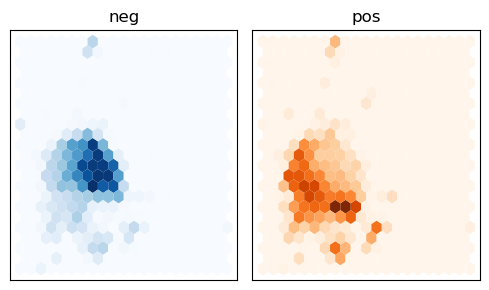

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(5,3))
axes = axes.flatten()
cmaps = ["Blues", "Oranges"]
labels = imdb["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### Training a simple classifier


In [62]:
#hide_output
# We increase `max_iter` to guarantee convergence 
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [63]:
lr_clf.score(X_valid, y_valid)

0.87568

Looking at the accuracy, it might appear that our model is just a bit better than random—but since we are dealing with an unbalanced multiclass dataset, it's actually significantly better. We can examine whether our model is any good by comparing it against a simple baseline. In Scikit-Learn there is a `DummyClassifier` that can be used to build a classifier with simple heuristics such as always choosing the majority class or always drawing a random class. In this case the best-performing heuristic is to always choose the most frequent class, which yields an accuracy of about 35%:

In [64]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.5

So, our simple classifier with DistilBERT embeddings is significantly better than our baseline. We can further investigate the performance of the model by looking at the confusion matrix of the classifier, which tells us the relationship between the true and predicted labels:

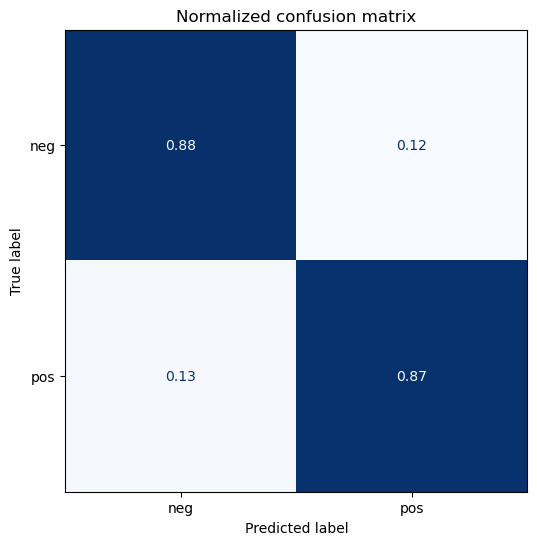

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

#### Loading a pretrained model

The first thing we need is a pretrained DistilBERT model like the one we used in the feature-based approach. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (six in our case), since this dictates the number of outputs the classification head has:

In [66]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

#### Defining the performance metrics


To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the accuracy of the model as follows:

In [67]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.

We'll tackle these steps in the next section.

#### Training the model

If you're running this code in a Jupyter notebook, you can log in to the Hub with the following helper function:

In [69]:
from huggingface_hub import notebook_login

notebook_login()

This will display a widget in which you can enter your username and password, or an access token with write privileges. You can find details on how to create access tokens in the [Hub documentation](https://huggingface.co/docs/hub/security#user-access-tokens). If you're working in the terminal, you can log in by running the following command:

```bash
$ huggingface-cli login
```

To define the training parameters, we use the `TrainingArguments` class. This class stores a lot of information and gives you fine-grained control over the training and evaluation. The most important argument to specify is `output_dir`, which is where all the artifacts from training are stored. Here is an example of `TrainingArguments` in all its glory:

In [87]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(imdb_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`: 

In [88]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=imdb_encoded["train"],
                  eval_dataset=imdb_encoded["test"],
                  tokenizer=tokenizer)
trainer.train();

/home/KH-NLPbookstudygroup/Chapter 2/Homework/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/KevinHH/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.
/home/python3.10/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.263400,0.188729,0.927480,0.926762
2,0.146700,0.231239,0.932080,0.932437


Looking at the logs, we can see that our model has an $F_1$-score on the validation set of around 92% - this is a significant improvement over the feature-based approach!

We can take a more detailed look at the training metrics by calculating the confusion matrix. To visualize the confusion matrix, we first need to get the predictions on the validation set. The `predict()` method of the `Trainer` class returns several useful objects we can use for evaluation:

In [89]:
# hide_output
preds_output = trainer.predict(imdb_encoded["test"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [90]:
preds_output.metrics

{'test_loss': 0.23123867809772491,
 'test_accuracy': 0.93208,
 'test_f1': 0.9324367340442463,
 'test_runtime': 186.9423,
 'test_samples_per_second': 133.731,
 'test_steps_per_second': 8.361}

It also contains the raw predictions for each class. We can decode the predictions greedily using `np.argmax()`. This yields the predicted labels and has the same format as the labels returned by the Scikit-Learn models in the feature-based approach:

In [91]:
y_preds = np.argmax(preds_output.predictions, axis=1)

With the predictions, we can plot the confusion matrix again:

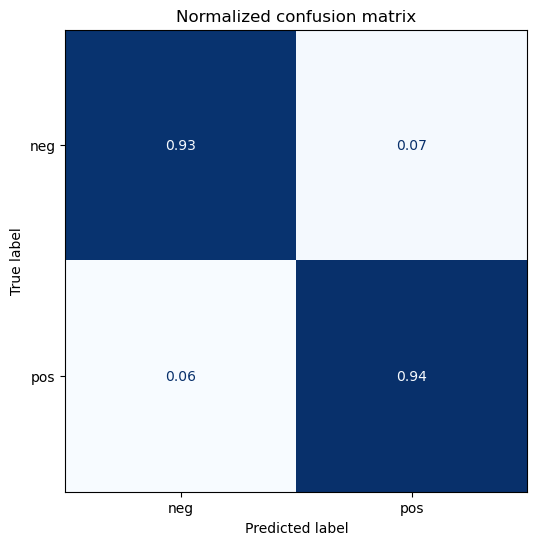

In [92]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix.  The `love` category is still often confused with `joy`, which seems natural. `surprise` is also frequently mistaken for `joy`, or confused with `fear`. Overall the performance of the model seems quite good, but before we call it a day, let's dive a little deeper into the types of errors our model is likely to make.

#### Saving and sharing the model


The NLP community benefits greatly from sharing pretrained and fine-tuned models, and everybody can share their models with others via the Hugging Face Hub. Any community-generated model can be downloaded from the Hub just like we downloaded the DistilBERT model. With the `Trainer` API, saving and sharing a model is simple:

In [ ]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

We can also use the fine-tuned model to make predictions on new tweets. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did in <<chapter_introduction>>. First, let's load the pipeline: